# Espectro $\gamma$ de diversas fontes comerciais

Após a calibração (e verificação da mesma), tomamos espectros de fontes comerciais de ${}^{133}$Ba, ${}^{109}$Cd, ${}^{57}$Co, ${}^{60}$Co, 
${}^{137}$Cs e ${}^{54}$Mn. Abaixo graficamos os espectros obtidos, bem como registramos os valores medidos e da literatura para as linhas detectadas, e o desvio percentual entre os mesmos.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import peakutils
import sys

sys.path.insert(0, "../")

from scipy.optimize import curve_fit
from scipy.signal import gaussian
from scipy.ndimage import filters
from scipy.integrate import simps

from common import *

%matplotlib inline

In [2]:
data_dir = '../../dados/'
arquivos = {
    'ba133': os.path.join(data_dir, 'ba133_15032017_1718.tsv'),
    'cd109': os.path.join(data_dir, 'cd109_15032017_1653.tsv'),
    'co57': os.path.join(data_dir, 'co57_15032017_1734.tsv'),
    'co60': os.path.join(data_dir, 'co60_15032017_1752.tsv'),
    'cs137': os.path.join(data_dir, 'cs137_15032017_1705.tsv'),
    'mn54': os.path.join(data_dir, 'mn54_15032017_1624.tsv'),
    'th232': os.path.join(data_dir, 'th232_15032017_1716.tsv'),
    'na22': os.path.join(data_dir, 'na22_15032017_1622.tsv'),
}

Amostra:  cd109
Variância canais:  [ 0.00152321] 
Variância calibração:  [ 1.50568135]
Amostra:  mn54
Variância canais:  [ 0.00798933] 
Variância calibração:  [ 4.91662306]
Amostra:  co57
Variância canais:  [ 0.00367904] 
Variância calibração:  [ 1.57902117]
Amostra:  co60
Variância canais:  [ 0.01575704  0.08544647  0.02458567] 
Variância calibração:  [ 1.92183904  5.45827993  7.05178485]
Amostra:  cs137
Variância canais:  [ 0.01109292  0.00447263] 
Variância calibração:  [ 1.81518836  3.94389596]
Amostra:  ba133
Variância canais:  [ 0.01687364] 
Variância calibração:  [ 2.39687792]
Amostra:  th232
Variância canais:  [ 0.00372205  0.02548894  0.07418951  0.06353538  0.07935464] 
Variância calibração:  [  1.92714673   3.47089445   5.51215936  10.04323462  14.21767824]
Amostra:  na22
Variância canais:  [ 0.00930438  0.00336595  0.06639372  0.00953935  0.04750815] 
Variância calibração:  [  1.76863288   3.15567291   6.07444322   7.76781451  11.64249739]


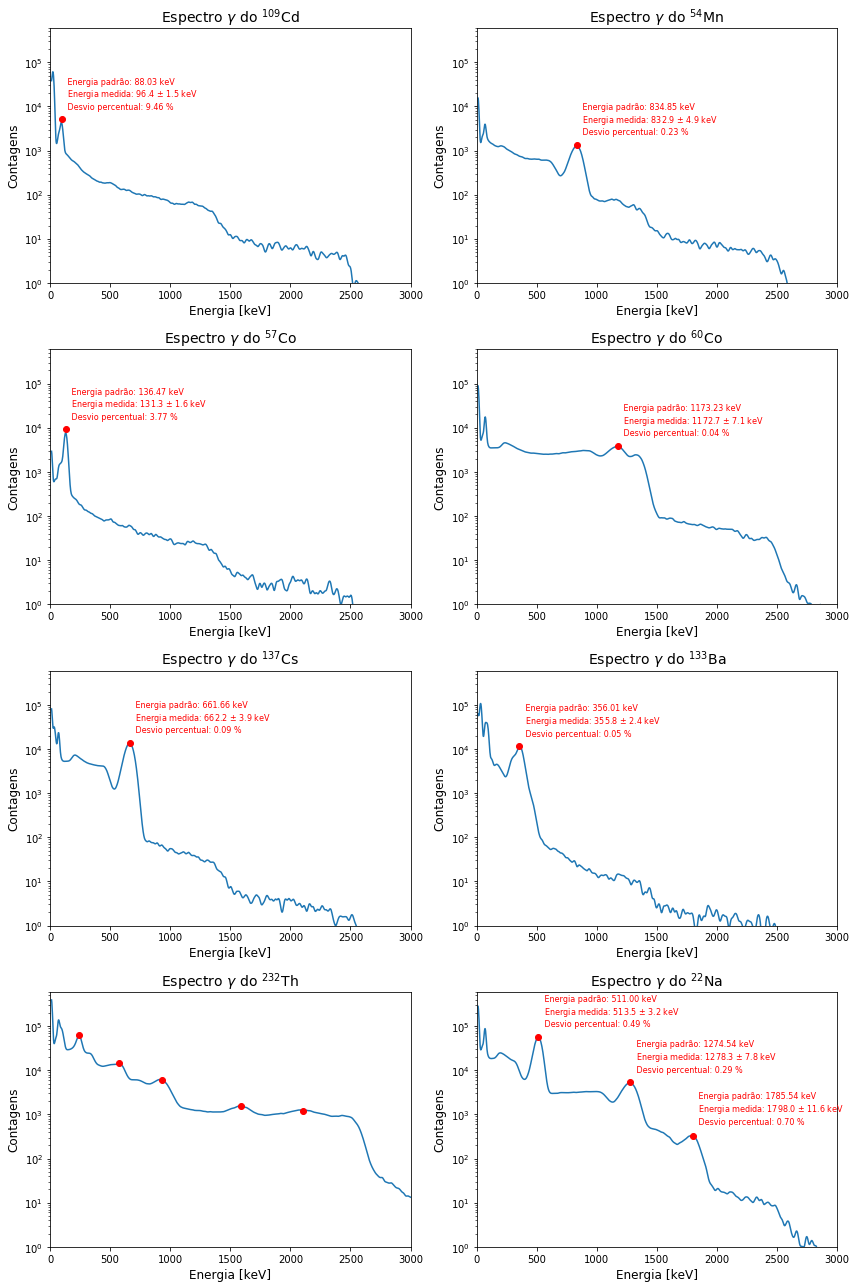

In [3]:
energias_padrao = []
canais_medidos = []
energias_medidas = []
incertezas_energias = []
pars_calibracao = np.array([3.8215880409588541e-05, 0.031908378390707419, 6.140984458104163])
incertezas_calibracao = np.array([2.0005452742905427e-05, 0.013574765061956408, 2.0394318835612819])

fig = plt.figure(figsize=(12, 18))
for k, amostra in enumerate(arquivos):
    ax = fig.add_subplot(4, 2, k + 1)
    fig.tight_layout()
    ax.set_ylim([1, 600000])
    ax.set_xlim([0, 3000])
    ax.set_yscale('log')
    
    # carrega e suaviza dados para amostra
    canais, contagens = load_data(arquivos[amostra])
    energias = calibracao(canais, pars_calibracao)
    contagens_smooth = smooth(contagens, 3)
    
    # carrega picos da amostra
    canais_picos, contagens_picos, canais_err = get_peak_points(arquivos[amostra], amostra, cut=0, return_channel=True)
    energias_picos = calibracao(canais_picos, pars_calibracao)
    variancia_canais = ((2 * pars_calibracao[0] * canais_picos + pars_calibracao[1]) * canais_err) ** 2
    variancia_calibracao = (incertezas_calibracao[0] ** 2 * canais_picos ** 4 + incertezas_calibracao[1] ** 2 * canais_picos ** 2 + 
        incertezas_calibracao[2])
    # imprime contribuições da calibração e da incerteza na determinação dos picos para a variância
    print("Amostra: ", amostra)
    print('Variância canais: ', np.sqrt(variancia_canais), '\nVariância calibração: ', np.sqrt(variancia_calibracao))
    incerteza_energias_picos = np.sqrt(variancia_canais + variancia_calibracao)
    
    # filtra picos
    if amostra is not 'na22':
        energias_picos_f, indexes_f, testemunhas = filter_peaks(energias_picos, [amostra], cut=0.2, tolerance=10)
    else:
        indexes_f = [1, 3, 4]
        energias_picos_f = [energias_picos[i] for i in indexes_f]
        energias_padrao_na = [511.0, 1274.537, 511 + 1274.537]
        testemunhas = {
            energias_picos_f[i]: [(energias_padrao_na[i], 'na22', np.nan)] for i,_ in enumerate(indexes_f)
        }
    incerteza_energias_f = [incerteza_energias_picos[i] for i in indexes_f]
    contagens_picos_f = [contagens_picos[i] for i in indexes_f]
    canais_picos_f = [canais_picos[i] for i in indexes_f]
    
    # obtêm energia padrão e desvio dos picos
    print_desvio = True
    try:
        energia_padrao, _, _ = testemunhas[energias_picos_f[0]][-1]
    except IndexError:
        print_desvio = False
    
    # plota
    amostra_latex = r"${}^{" + amostra[2:] + "}$" + amostra[0].upper() + amostra[1]
    title = "Espectro $\gamma$ do " + amostra_latex
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Energia [keV]", fontsize=12)
    ax.set_ylabel("Contagens", fontsize=12)
    _ = ax.plot(energias, contagens_smooth)
    
    if print_desvio:
        _ = ax.plot(energias_picos_f, contagens_picos_f, 'ro')
        for i, energia_pico in enumerate(energias_picos_f):
            contagem_pico = contagens_picos_f[i]
            incerteza_energia = incerteza_energias_f[i]
            canal_pico = canais_picos_f[i]
            energia_padrao, _, _ = testemunhas[energia_pico][-1]
            desvio = np.abs(energia_pico - energia_padrao)*100.0/energia_padrao
            point_label = """
 Energia padrão: {:.2f} keV\n Energia medida: {:.1f} $\pm$ {:.1f} keV\n Desvio percentual: {:.2f} %
            """.format(
                    energia_padrao, energia_pico, incerteza_energia, desvio
                )
            ax.text(energia_pico+30, contagem_pico+30, point_label, color='red', fontsize=8)
            energias_padrao.append(energia_padrao)
            canais_medidos.append(canal_pico)
            energias_medidas.append(energia_pico)
            incertezas_energias.append(incerteza_energia)
    else:
        _ = ax.plot(energias_picos, contagens_picos, 'ro')
fig.savefig("todos_espectros.pdf")
    

Note que os desvios dos valores medidos com relação aos valores padrão do CODATA são inferiores a 10 %. Observe também que a principal contribuição para as incertezas nas medições das energias dos picos é devidas à calibração, e não à determinação do centróide dos picos, que é feita com bastante precisão.

Chi quadrado:  14.4618442512


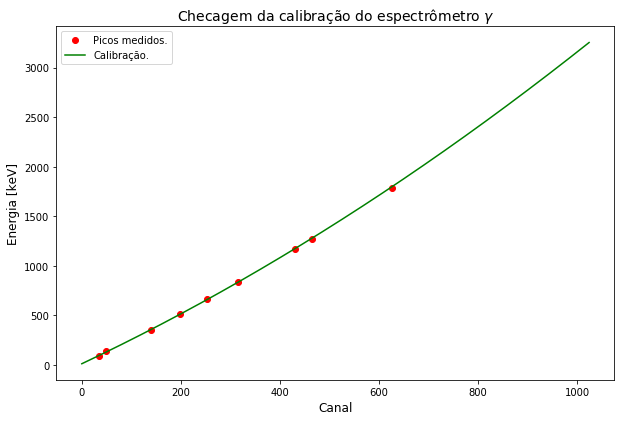

In [4]:
fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
ax.set_xlabel('Canal', fontsize=12)
ax.set_ylabel('Energia [keV]', fontsize=12)

energias_medidas = np.array(energias_medidas)
incertezas_energias = np.array(incertezas_energias)
canais_medidos = np.array(canais_medidos)

#calcula chi quadrado
graus_liberdade = len(energias_medidas) - 6  # descartando graus de liberdade dos pontos usados para o ajuste
chi_sq = 1.0 / graus_liberdade * np.sum((energias_medidas - energias_padrao)**2 / incertezas_energias**2)
print("Chi quadrado: ", chi_sq)

channels = np.linspace(0, 1024, 1024)
energies_ics = calibracao(channels, pars_calibracao)


ax.plot(canais_medidos, energias_padrao, 'ro', label='Picos medidos.')
ax.plot(channels, energies_ics, 'g', label='Calibração.')
ax.set_title("Checagem da calibração do espectrômetro $\gamma$", fontsize=14)
ax.legend()
fig.savefig("checagem_calibracao.pdf")

Note que o valor de $\chi^2$ obtido é relativamente alto, embora o ajuste seja visualmente bom. Isto provavelmente significa que há incertezas que não estão sendo levadas em consideração.

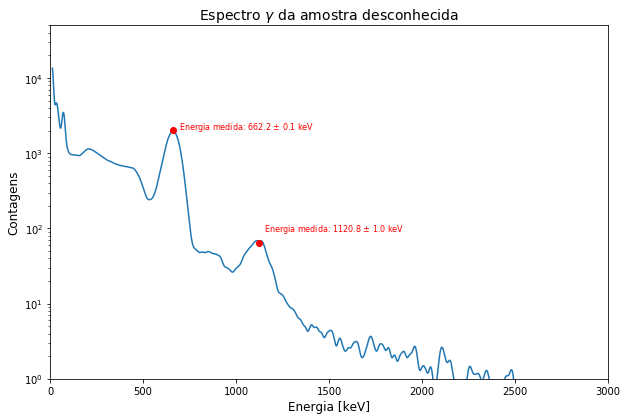

In [5]:
arquivo_desconhecida = os.path.join(data_dir, 'desconhecida_15032017_1800.tsv')

fig = plt.figure(figsize=(10, 6.5))
ax = fig.add_subplot(111)
ax.set_ylim([1, 50000])
ax.set_xlim([0, 3000])
ax.set_yscale('log')

# carrega e suaviza dados para amostra
canais, contagens = load_data(arquivo_desconhecida)
energias = calibracao(canais, pars_calibracao)
contagens_smooth = smooth(contagens, 3)

# carrega picos
peak_xs, peak_ys, peak_xs_err = get_peak_points(arquivo_desconhecida, None)
peak_xs = peak_xs[1:]
peak_ys = peak_ys[1:]
peak_xs_err = peak_xs_err[1:]

title = "Espectro $\gamma$ da amostra desconhecida"
ax.set_title(title, fontsize=14)
ax.set_xlabel("Energia [keV]", fontsize=12)
ax.set_ylabel("Contagens", fontsize=12)
ax.plot(energias, contagens_smooth)
for peak_x, peak_y, peak_x_err in zip(peak_xs, peak_ys, peak_xs_err):
    point_label = "Energia medida: {:.1f} $\pm$ {:.1f} keV".format(
                    peak_x, peak_x_err)
    ax.text(peak_x+30, peak_y+30, point_label, color='red', fontsize=8)
ax.plot(peak_xs, peak_ys, 'ro')
fig.savefig("amostra_desconhecida.pdf")

A amostra possui duas linhas visíveis: uma corresponde à conhecida linha do ${}^{137}$Cs em 661.66 keV. A outra é próxima à linha de 1120.287 keV do ${}^{214}$Bi, que faz parte da série do ${}^{226}$Ra. A amostra com certeza contêm ${}^{137}$Cs, mas provavelmente possui outros isótopos, e não conseguimos conclusivamente identificá-los com o espectro obtido.